In [11]:
import yaml
import logging

In [12]:
# Initialize the logger once as the application starts up.
with open("../logging.yaml", 'rt') as f:
    config = yaml.safe_load(f.read())
    logging.config.dictConfig(config)
 
# Get an instance of the logger and use it to write a log!
# Note: Do this AFTER the config is loaded above or it won't use the config.
logger = logging.getLogger("py-clean-arch")
logger.info("Configured the logger!")

2023-01-24 09:13:47,450 - py-clean-arch - INFO - Configured the logger!


In [3]:
def stop_database():
   logging.info("stopping db") 
def start_database():
    logging.info("starting db")

class DBHandler:
    """for a context manager define.
        1 __enter__ method
        2 __exit__ method
    """
    def __enter__(self):
        stop_database()
        return self
    def __exit__(self, exc_type, ex_value, ex_traceback):
        start_database()

def db_backup():
    logging.info("doing backup")

def check():
    with DBHandler():
        db_backup()

In [4]:
check()

2023-01-09 09:31:02,486 - root - INFO - stopping db
2023-01-09 09:31:02,492 - root - INFO - doing backup
2023-01-09 09:31:02,495 - root - INFO - starting db


In [5]:
# rewriting the above using the context manager lib
import contextlib

@contextlib.contextmanager
def db_handler():
    try:
        stop_database()
        yield
    finally:
        start_database()


with db_handler():
    db_backup()

2023-01-09 09:31:02,526 - root - INFO - stopping db
2023-01-09 09:31:02,531 - root - INFO - doing backup
2023-01-09 09:31:02,538 - root - INFO - starting db


In [6]:
# other way of writing context manager by extending a class
class dbhandler_decorator(contextlib.ContextDecorator):
    def __enter__(self):
        stop_database()
        return self
    
    def __exit__(self, ext_type, ex_value, ex_traceback):
        start_database()



@dbhandler_decorator()
def offline_backup():
    db_backup()

In [7]:
offline_backup()

2023-01-09 09:31:02,590 - root - INFO - stopping db
2023-01-09 09:31:02,592 - root - INFO - doing backup
2023-01-09 09:31:02,595 - root - INFO - starting db


In [8]:
#if you want to access the object
with dbhandler_decorator() as handler:
    db_backup()

2023-01-09 09:31:02,622 - root - INFO - stopping db
2023-01-09 09:31:02,623 - root - INFO - doing backup
2023-01-09 09:31:02,625 - root - INFO - starting db


In [9]:
# if you need to create your own getter and setter with some functionality use properties decorator
class Coordinate:
    def __init__(self, lat: float, long: float) -> None:
        self._latitude = self._longitude = None
        self.latitude = lat
        self.longitude = long

    @property
    def latitude(self) -> float:
        return self._latitude

    @latitude.setter
    def latitude(self, lat_value: float) -> None:
        if lat_value not in range(-90, 90 + 1):
            raise ValueError(f"{lat_value} is an invalid value for latitude")
        self._latitude = lat_value

    @property
    def longitude(self) -> float:
        return self._longitude

    @longitude.setter
    def longitude(self, long_value: float) -> None:
        if long_value not in range(-180, 180 + 1):
            raise ValueError(f"{long_value} is an invalid value for longitude")
        self._longitude = long_value

    def __repr__(self) -> str:
        return f"Coordinate(lat: {self.latitude}, lon: {self.longitude})"

In [10]:
a = Coordinate(90,33)
print(a)
a.latitude = 50
print(a)

Coordinate(lat: 90, lon: 33)
Coordinate(lat: 50, lon: 33)


# An example of an Rtrie

In [1]:
from typing import List
from dataclasses import dataclass, field

R = 26

@dataclass
class RTrieNode:
    size = R
    value: int
    next_: List["RTrieNode"] = field(
        default_factory=lambda: [None] * R)

    def __post_init__(self):
        if len(self.next_) != self.size:
            raise ValueError(f"Invalid length provided for next list")

# about iterables

In [2]:
from datetime import timedelta

class DateRangeIterable:
    """An iterable that contains its own iterator object."""

    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        self._present_day = start_date

    def __iter__(self):
        return self
        
    def __next__(self):
        if self._present_day >= self.end_date:
            raise StopIteration()
        today = self._present_day
        self._present_day += timedelta(days=1)
        return today

In [4]:
import datetime
start = datetime.date(2015,10,20)
end = datetime.date(2015,10,25)

for e in DateRangeIterable(start, end):
    print(e)

2015-10-20
2015-10-21
2015-10-22
2015-10-23
2015-10-24


In [6]:
class DateRangeSequence:

    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        self._range = self._create_range()

    def _create_range(self):
        days = []
        current_day = self.start_date
        while current_day < self.end_date:
            days.append(current_day)
            current_day += timedelta(days=1)
        return days
    
    def __getitem__(self, day_no):
        return self._range[day_no]
        
    def __len__(self):
        return len(self._range)

In [14]:
from datetime import date
dseq = DateRangeSequence(date(2018,10,10), date(2018,10,15))
logger.info(f"{dseq[2]}")
max (dseq)

2023-01-24 09:13:55,127 - py-clean-arch - INFO - 2018-10-12


datetime.date(2018, 10, 14)

In [18]:
from typing import Any

# About Dynamic attributes

In [27]:
class DynamicAttributes:
    def __init__(self, attribute) -> None:
        self.attribute = attribute

        """
        - when asking for an attribute, python will try to find it using this method
        - raise Attribute error so that the default value will be triggered
        """
    def __getattr__(self, __name: str) -> Any:
        if __name.startswith("fallback_"):
            replaced = __name.replace("fallback_","")
            return f"[fallback resolved] {replaced}"

        raise AttributeError(
             f"{self.__class__.__name__} has no attribute {__name}"
        )

In [40]:
dyn = DynamicAttributes("value")
dyn.__dict__["addin_new_attr"] = "new attr"
print(dyn.__dict__)
print(dyn.attribute)
print(getattr(dyn,"notfoundattribute")) #will trigger exception


{'attribute': 'value', 'addin_new_attr': 'new attr'}
value


AttributeError: DynamicAttributes has no attribute notfoundattribute

In [35]:
print(getattr(dyn,"notfoundattribute","default"))#will use default,

default


# About callable objects

In [46]:
from collections import defaultdict

"""
a class that remember how many times an argument has been passed
"""
class CallCount:
    def __init__(self) -> None:
        self._count = defaultdict(int)

    """
        When we have an object, a statement like this, object(*args, **kwargs), 
        is translated in Python to object.__call__(*args, **kwargs).
        This method is useful when we want to create callable objects that will work 
        as parametrized functions, or in some cases, functions with memory
    """
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        self._count[args[0]] += 1
        return self._count[args[0]]

In [47]:
cc = CallCount()
print(cc(1))
print(cc(2))
print(cc(1))

1
1
2


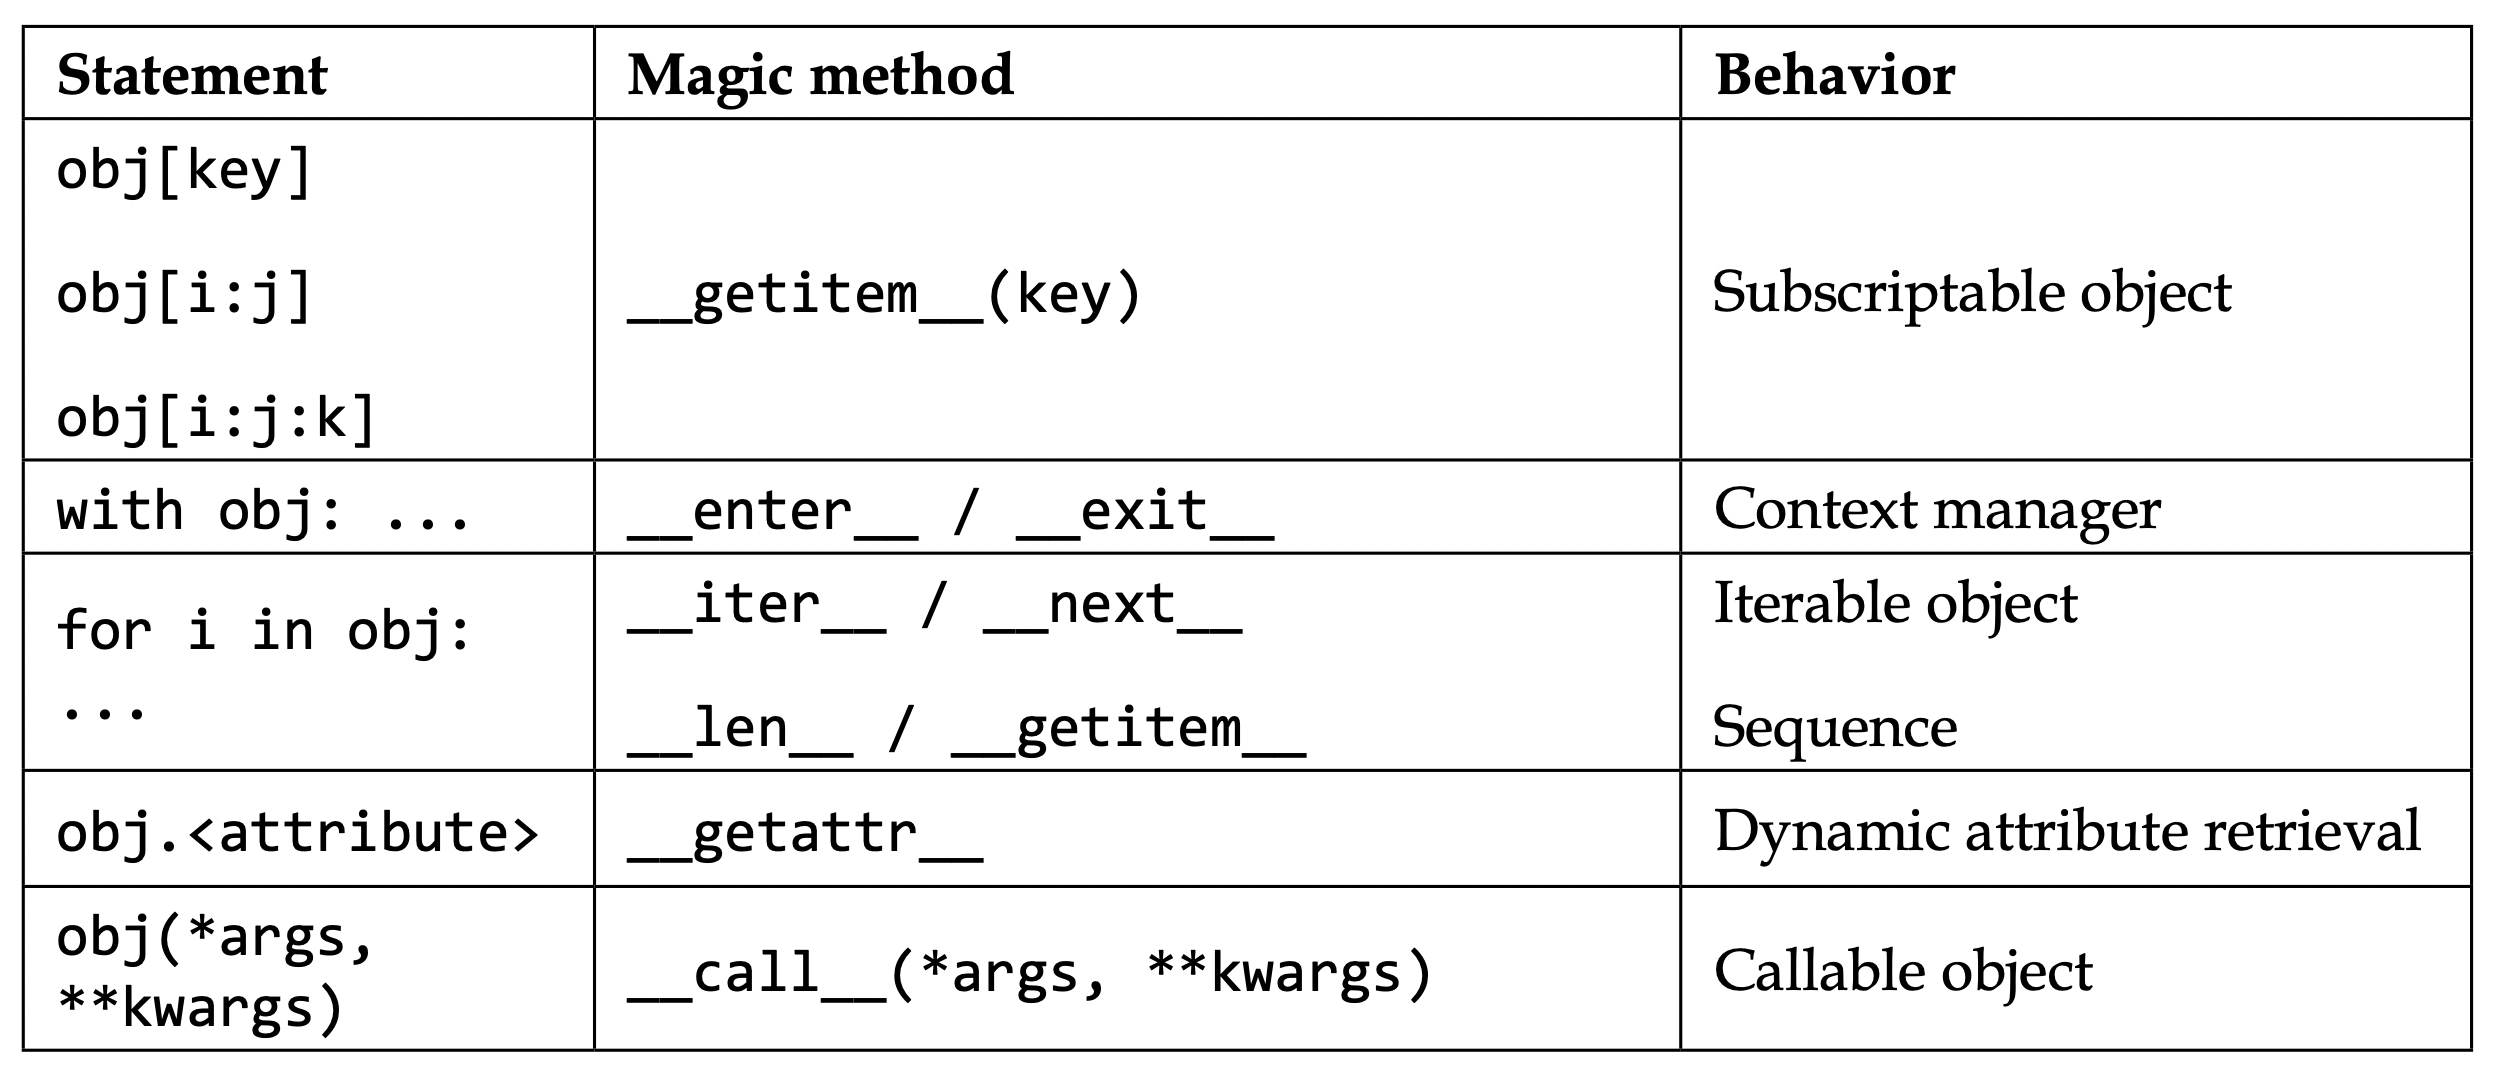